# Question Answering Using LLM and Saving Results

In this notebook, we will perform several tasks:

1. Extract question answering data from a JSON file.
2. Use a language model (LLM) to generate answers to the questions.
3. Calculate the similarity between generated answers and the true answers using embeddings.
4. Calculate various metrics to evaluate the generated answers.
5. Visualize the data and results.
6. Save the results to a JSON file.

We will also include a step-by-step explanation and code to perform these tasks.

## Libraries and Dependencies

First, let's import the necessary libraries. We need libraries for JSON handling, regular expressions, concurrent processing, API interactions, data manipulation, and metric calculations.


In [ ]:
pip install openai pandas tiktoken numpy matplotlib rouge bert-score


In [118]:
import json
import re
import pandas as pd
import concurrent.futures
import openai
import numpy as np
import tiktoken
import math
from rouge import Rouge
from bert_score import score
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from multiprocessing import Pool

OPENAI_API_KEY = '{openai_key}'


## Data Loading and Extraction

We will load the data from a JSON file using the `QADataExtractor` class. This class will handle reading the JSON file and extracting the relevant information needed for question answering.

### 2.1. Strip Attribution Tokens

We define a helper function to strip attribution tokens from the text. This helps in cleaning the text data.


In [119]:
def strip_attribution_tokens(text):
    """Strip the attribution tokens from an answer."""
    return re.sub(r'\[ ([1-9]) ([^\[\]]*) \]', r'\2', text)


### 2.2. QADataExtractor Class

This class will handle loading the JSON data and extracting necessary information. It includes methods for loading data from a file and extracting information into a structured format.


In [120]:

class QADataExtractor:
    def __init__(self, file_path):
        self.data = self._load_data(file_path)
        self.extracted_data = []

    def _load_data(self, file_path):
        with open(file_path, 'r') as file:
            return json.load(file)

    def get_data(self):
        return self.data

    def extract_data(self):
        for item in self.data:
            source_count = item.get('source_count')
            unique_id = item.get('unique_id')
            question = item.get('question')
            summary = item.get('summary')
            answer = strip_attribution_tokens(summary)

            combined_entries = {}
            for i in range(1, source_count + 1):
                title_key = f'title{i}'
                source_key = f'source{i}'
                title = item.get(title_key, "")
                source = item.get(source_key, "")
                if title or source:
                    combined_entries[f'{title_key}_{source_key}'] = {'title': title, 'source': source}

            extracted_info = {
                'source_count': source_count,
                'unique_id': unique_id,
                'question': question,
                'summary': summary,
                'answer': answer,
                'combined_entries': combined_entries
            }

            self.extracted_data.append(extracted_info)

    def get_extracted_data(self):
        return self.extracted_data


## Embedding and Similarity Calculation

We will use embeddings to calculate the cosine similarity between the generated answers and the true answers.

### 3.1. EmbeddingClient Class

This class will interact with the OpenAI API to get embeddings for given texts.


In [121]:
class EmbeddingClient:
    def __init__(self, api_key, model="text-embedding-3-small", max_tokens=8000):
        openai.api_key = api_key
        self.model = model
        self.max_tokens = max_tokens

    def get_embeddings(self, texts):
        embeddings = []
        for text in texts:
            text = text.replace("\n", " ")
            response = openai.embeddings.create(input=[text], model=self.model)
            embeddings.append(response.data[0].embedding)
        return embeddings


### 3.2. SimilarityCalculator Class

This class provides methods to calculate the cosine similarity between two embeddings.


In [122]:
class SimilarityCalculator:
    @staticmethod
    def cosine_similarity(embedding1, embedding2):
        dot_product = np.dot(embedding1, embedding2)
        norm1 = np.linalg.norm(embedding1)
        norm2 = np.linalg.norm(embedding2)
        return dot_product / (norm1 * norm2)

## Question Answering with LLM

We will use the OpenAI API to generate answers to the questions using the extracted data.

### 4.1. OpenAIAnswerGenerator Class

This class will handle generating answers using the OpenAI API.


In [123]:
class OpenAIAnswerGenerator:
    def __init__(self, api_key, model):
        openai.api_key = api_key
        self.model = model

    def generate_answer(self, question, sources, prompt):
        prompt = prompt(question, sources)
        response = openai.chat.completions.create(
            model=self.model,
            messages=prompt,
            max_tokens=500,
            temperature=0,
            seed=12345
        )
        answer = response.choices[0].message.content.strip()
        return answer


### 4.2. Simple Prompt

This function generates the prompt to be used by the OpenAI API for generating answers.


In [124]:
def simple_prompt(question, sources):
    sources_text = "\n\n".join([f"Title {index + 1}: {v['title']}\nSource {index + 1}: {v['source']}"
                                for index, v in enumerate(sources.values())])
    prompt = [
        {"role": "system", "content": f"""You are a helpful assistant designed for question answering.
                Your input will be the question, several candidate documents each with its title, ID, and content.
                Your role is to determine if a comprehensive answer can be constructed from the information available across the provided documents and, if so, synthesize this information into a coherent answer.
                * You are not allowed to use any other knowledge you might have, other than what's in the documents.
                * If it is not possible to construct a direct answer from the information in the documents, you must return the string "null" as the answer.
                * If you know the answer but it is not supported by the information in the documents, you must return the string "null" as the answer.
                * Your synthesized answer must be less than 500 characters long.
                * Content snippets of each document may be redacted, cut, or incomplete.
                # Context:
                {sources_text}"""},
        {"role": "user", "content": f"{question}"}
              ]
    return prompt

### 4.3 Prompt 2 - retrieve source docs ID's

In [125]:
def simple_prompt2(question, sources):
    sources_text = "\n\n".join([f"Document {index + 1}:\n - Title: {v['title']}\n - Document ID: Source{index + 1}\n: - Content: {v['source']}"
                                for index, v in enumerate(sources.values())])

    prompt = [
        {"role": "system", "content": f"""You are a helpful assistant designed for question answering.
            Your input will be the question, several candidate documents each with its title, ID and content.
            Your role is to determine if a comprehensive answer can be constructed from the information available across the provided documents and, if so, synthesize this information into a coherent answer.
            * Your response must always be a valid JSON in the format:
              {{
                "answer": "",
                "sources": []
              }}
            * Specify the ID's of the documents from which the answer was synthesized in the "sources" array.
            * You are not allowed to use any other knowledge you might have, other than what's in the documents.
            * Your synthesized answer must be less than 500 characters long.
            * If it is not possible to construct a direct answer from the information in the documents, set the null value in the json "answer" field.
            * If you know the answer but it is not supported by the information in the documents, set the null in the json "answer" field.
            * Content snippet of each document may be redacted, cut, or incomplete.
            # Context:
            {sources_text}"""},
        {"role": "user", "content": f"{question}"}
    ]
    return prompt

### 4.4 Prompt 3 - Few-Shots

In [137]:
def prompt_few_shots(question, sources):
    sources_text = "\n\n".join([f"Document {index + 1}:\n - Title: {v['title']}\n - Document ID: Source{index + 1}\n: - Content: {v['source']}"
                          for index, v in enumerate(sources.values())])
    prompt = [{"role": "system", "content":  f"""
    You are an AI assistant.
  You are being used as part of a Q&A system.
  We accept user requests or questions and use semantic search to find candidate documents that may contain pieces of information relevant to the question. Your role is to determine if a comprehensive answer can be constructed from the information available across the provided documents and, if so, synthesize and attribute the sources.
  Your answer must be in the same language as the question.
  * Your input will be the question, several candidate documents each with its title, document ID, and content.
  * Your response must always be a valid JSON in the format:
  {{
   "answer": ""
   "sources": []
  }}
  * You may synthesize the answer using information from multiple documents. If the documents provide contradictory information or multiple answers, include all possible answers in your response.
  * Specify the ID's of the documents from which the answer was synthesized in the "sources" array.
  * You are not allowed to use any other knowledge you might have, other than what's in the documents.
  * Your synthesized answer must be less than 500 characters long.
  * If it is not possible to construct a direct answer from the information in the documents, set the null value in the json "answer" field.
  * If you know the answer but it is not supported by the information in the documents, set the null in the json "answer" field.
  * Content snippet of each document may be redacted, cut, or incomplete.
  ** Pay attention to return all possible answers!!
  
  Let me share a couple examples:
- Example 1:  
  # Document 1:
    - Title: "Ahmed Issack Hassan"
    - Document ID : "source1" 
    - Content: "He later went into private legal practice. Issack is also a Certified Public Secretary of Kenya (CPSK) and a member of the Law Society of Kenya (LSK), East African Law Society (EALS), International Commission of Jurists (ICJ) (Kenya Chapter), Institute of Certified Public Secretaries of Kenya (ICPS), Association of Professional Societies of East Africa (APSEA), Commonwealth Lawyers Association (CLA) and the International Bar Association (IBA). Ahmed Issack Hassan Ahmed Issack Hassan is the former Chairperson of the Independent Electoral and Boundaries Commission (IEBC) of the Republic of Kenya from November 2011 to October 6th 2016. Before that he was the Chairperson of the Interim Independence Electoral Commission."
  
  # Document 2:
    - Title: "Foreign territories of Singapore"
    - Document ID : "source2" 
    - Content: "Several other rules and laws of the respective country still apply in these areas and those countries reserve full rights to suspend or expel diplomatic missions of Singapore without compensation. Pedra Branca is currently owned by Singapore. This piece of land came into full possession of Singapore after an International Court of Justice (ICJ) ruling that awarded Pedra Branca to Singapore following a Pedra Branca dispute with Malaysia in 2008. However Singapore had already been exercising control over the island when the Horsburgh Lighthouse was built on it in 1851. This territory is under Singapore's jurisdiction and Singapore."
  
  The question: what does icj stand for?
  The response: ICJ stands for either the "International Commission of Jurists" or the "International Court of Justice".
  
  - Example 2:  
  # Document 1:
    - Title: "Robert Weiss (therapist)"
    - Document ID : "source1" 
    - Content: "The AIDS crisis led him to want to study sexual compulsions, so he earned a master's in social work at University of California, Los Angeles, then took a job working with Patrick Carnes, who did pioneering work in the field. In 1995 he opened his own clinic, the Sexual Recovery Institute (SRI), which offered intensive outpatient programs. This was shortly before internet pornography became prevalent and people began struggling with compulsive viewing and internet dating. However, people coming to SRI often had to pay out of pocket, since its programs were not covered by insurance, and Weiss sold SRI to Elements Behavioral Health in 2011. Weiss became Elements' senior."
  
  # Document 2:
    - Title: "Robert K. Weiss"
    - Document ID : "source2"
    - Content: "Robert K. Weiss is an American film and television producer. His productions include films by director John Landis, producer Lorne Michaels, and the \u201cZ. A. Z.\u201d team of Jim Abrahams, David Zucker, and Jerry Zucker. He also co-created the science-fiction TV series \"Sliders\". He is a graduate of Southern Illinois University Carbondale. Weiss has been the President and Vice Chairman of the X Prize Foundation since 1996. In the film \"Blues Brothers 2000\", the name of Robert K. Weiss is mentioned (to the confusion of Donald \"Duck\" Dunn) in a speech by Elwood Blues as the final."
  
  The question: where did robert weiss go to school?
  The response: Robert Weiss, the therapist, earned a master's in social work at University of California, Los Angeles, while Robert K. Weiss, the American film and television producer, is a graduate of Southern Illinois University Carbondale.
  
  - Example 3:  
  # Document 1:
    - Title: "Population pyramid"
    - Document ID : "source1" 
    - Content: "high and above population sub-replacement fertility level. The older population is declining over time due to a shorter life expectancy of sixty years. However, there are still more females than males in these ranges since women have a longer life expectancy. As reported by the \"Proceedings of the National Academy of Sciences,\" women tend to live longer than men because women do not partake in risky behaviors. Also, Weeks' \"Population: an Introduction to Concepts and Issues,\" considered that the sex ratio gap for the older ages will shrink due to women's health declining due to the effects of smoking, as."
  
  # Document 2:
    - Title: "Life expectancy"
    - Document ID : "source2" 
    - Content: "This biological difference occurs because women have more resistance to infections and degenerative diseases. In her extensive review of the existing literature, Kalben concluded that the fact that women live longer than men was observed at least as far back as 1750 and that, with relatively equal treatment, today males in all parts of the world experience greater mortality than females. Kalben's study, however, was restricted to data in Western Europe alone, where demographic transition occurred relatively early. In countries such as Hungary, Bulgaria, India and China, males continued to outlive females into the twentieth century. Of 72 selected causes of."
  
  The question: why do women tend to live longer than men?
  The response: According to sources, women tend to live longer than men because women do not partake in risky behaviors and because women have more resistance to infections and degenerative diseases.
  
  - Example 4:  
  # Document 1:
    - Title: "Transatlantic tunnel"
    - Document ID : "source1" 
    - Content: "At this speed, the travel-time between New York City and London would be less than one hour. Another modern variation, intended to reduce costs, is a submerged floating tunnel about below the ocean surface, in order to avoid ships, bad weather, and the high pressure associated with a much deeper tunnel near the sea bed. It would consist of 54,000 prefabricated sections held in place by 100,000 tethering cables. Each section would consist of a layer of foam sandwiched between concentric steel tubes, and the tunnel would also have reduced air pressure. Ideas proposing rocket, jet, scramjet, and air-pressurized tunnels for train transportation have also."
  
  # Document 2:
    - Title: "Boom Technology"
    - Document ID : "source2" 
    - Content: "$10 million, raising the company capital to $51 million: enough to build the XB-1 \u201cBaby Boom\u201d demonstrator and complete its testing, and to start early design work on the 55-seat airliner. Five hundred daily routes would be viable: at Mach 2.2 over water, New York City to London would be 3 hours and 15 minutes apart; Miami and Santiago, Chile would be 3 hours and 48 minutes apart. With of range, transpacific flights would require a refueling stop: San Francisco and Tokyo would be 5 hours and 30 minutes apart; Los Angeles and Sydney would be 6 hours and 45."
  
  The question: how long would it take to get from new york to london?
  The response: With reference to Transatlantic tunnel, the travel-time between New York City and London would be less than one hour. Other sources state that with Boom Technology, New York City to London would be 3 hours and 15 minutes apart.

  # Context:
  {sources_text}"""},
  {"role": "user", "content": f"{question}"}
    ]
  
    return prompt


### 4.5  Prompt: Dynamic Few-shots

Dynamic few-shot prompting involves selecting a set of example question-answer pairs that are relevant to the current question being asked. This helps the model understand the context and format of the expected response. The key steps to implement dynamic few-shot prompting are:

1. Collect Example Pairs: Gather a diverse set of example question-answer pairs.
2. Similarity Calculation: Compute the similarity between the current question and each example question.
3. Select Relevant Examples: Choose the top-k examples that are most similar to the current question.
4. Construct the Prompt: Include these examples in the prompt before the actual question.


In [18]:
file_path = './data/train.json'
data_extractor = QADataExtractor(file_path)
data_extractor.extract_data()
dataset = data_extractor.get_extracted_data()
embedding_client = EmbeddingClient(api_key=OPENAI_API_KEY)
questions = [entry['question'] for entry in dataset]
question_embeddings = embedding_client.get_embeddings(questions)
k = 4


def compute_question_similarities(current_question, question_embeddings, embedding_client):
    current_embedding = embedding_client.get_embeddings([current_question])[0]
    similarities = cosine_similarity([current_embedding], question_embeddings)[0]
    return similarities

def select_top_k_similar_questions(current_question, question_embeddings, dataset, embedding_client, k=3):
    similarities = compute_question_similarities(current_question, question_embeddings, embedding_client)
    similarities = [similarity if similarity < 0.99 else -1 for similarity in similarities]
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [dataset[i] for i in top_k_indices]

def format_example(example):
    combined_entries = example['combined_entries']
    documents = "\n".join(
        [f"# Document {index + 1}:\n - Title: \"{v['title']}\"\n - Document ID: \"Source{index + 1}\"\n - Content: \"{v['source']}\""
         for index, v in enumerate(combined_entries.values())]
    )
    formatted_example = f"  {documents}\n\n  The question: {example['question']}\n  The response: {example['answer']}"
    return formatted_example


def dynamic_Few_shots_prompt(current_question, sources):
    selected_examples = select_top_k_similar_questions(current_question, question_embeddings, dataset, embedding_client, k)
    
    examples_prompt = "\n\n".join(
        [f"  - Example {i+1}:\n{format_example(ex)}" for i, ex in enumerate(selected_examples)]
    )
    
    sources_text = "\n\n".join(
        [f"# Document {index + 1}:\n - Title: {v['title']}\n - Document ID: Source{index + 1}\n - Content: {v['source']}"
         for index, v in enumerate(sources.values())]
    )
    
    prompt = [
        {"role": "system", "content": f"""You are an AI assistant.
  You are being used as part of a Q&A system.
  We accept user requests or questions and use semantic search to find candidate documents that may contain pieces of information relevant to the question. Your role is to determine if a comprehensive answer can be constructed from the information available across the provided documents and, if so, synthesize and attribute the sources.
  Your answer must be in the same language as the question.
  * Your input will be the question, several candidate documents each with its title, document ID, and content.
  * Your response must always be a valid JSON in the format:
  {{
   "answer": ""
   "sources": []
  }}
  * You may synthesize the answer using information from multiple documents. If the documents provide contradictory information or multiple answers, include all possible answers in your response.
  * Specify the ID's of the documents from which the answer was synthesized in the "sources" array.
  * You are not allowed to use any other knowledge you might have, other than what's in the documents.
  * Your synthesized answer must be less than 500 characters long.
  * If it is not possible to construct a direct answer from the information in the documents, set the null value in the json "answer" field.
  * If you know the answer but it is not supported by the information in the documents, set the null in the json "answer" field.
  * Do not describe the documents, the question.
  * Content snippet of each document may be redacted, cut, or incomplete.
  ** Pay attention to return all possible answers!! """},
        {"role": "assistant", "content": examples_prompt},
        {"role": "assistant", "content": f"{sources_text}"},
        {"role": "user", "content": f"{current_question}"}
    ]
    return prompt


In [27]:
def chain_of_though(question, sources):
    selected_examples = select_top_k_similar_questions(question, question_embeddings, dataset, embedding_client, k)
    
    examples_prompt = "\n\n".join(
        [f"  - Example {i+1}:\n{format_example(ex)}" for i, ex in enumerate(selected_examples)]
    )
    
    sources_text = "\n\n".join(
        [f"# Document {index + 1}:\n - Title: {v['title']}\n - Document ID: Source{index + 1}\n - Content: {v['source']}"
         for index, v in enumerate(sources.values())]
    )
    
    prompt = [
        {"role": "system", "content": f"""You are an helpful assistant designed for question answering.
        Your input will be the question, several candidate documents each with its title, ID, and content.
        Your role is to determine if a comprehensive answer can be constructed from the information available across the provided documents and, if so, synthesize this information into a coherent answer.
        You should follow these steps:
        1. Go over each document and try to answer the question separately using each document.
        2. For each document that contains an answer, save the smallest span of words from the document and ,that answer the question.
        3. If a document does not contain an answer, skip to the next document.
        4. create the answer, by concatenate all the saved span of words and other words from the document, separate by connectors words if possible. also provide all sources you used for the answer.
        
        Your response must always be a valid JSON in the format:
        {{
            "answer": "",
            "sources": [],
            "spans": []
        }}

        * You may synthesize the answer using information from multiple documents. If the documents provide contradictory information or multiple answers, include all possible answers in your response.
        * Specify the ID's of the documents from which the answer was synthesized in the "sources" array.
        * You are not allowed to use any other knowledge you might have, other than what's in the documents.
        * Your synthesized answer must be less than 500 characters long.
        * If it is not possible to construct a direct answer from the information in the documents, set the null value in the json "answer" field.
        * If you know the answer but it is not supported by the information in the documents, set the null in the json "answer" field. your are not allowed to use your knowledge.
        * Content snippet of each document may be redacted, cut, or incomplete.
        ** Pay attention to return all possible answers!!"""},
        {"role": "assistant", "content": "here some examples: \n" +  examples_prompt},
        {"role": "assistant", "content": f"now this is your turn, #content:\n {sources_text}"},
        {"role": "user", "content": f"The question: {question}\n Don't forget your answer must always be according to the json."}
    ]
    return prompt

## Saving Results to JSON

We will process each entry using the LLM to generate answers and save the results to a JSON file.

### 5.1. Process Entry Function

This function processes a single entry by generating an answer, calculating the similarity, and returning the results.


In [140]:
def extract_source_numbers(source_strings):
    """
    Extracts source numbers from the source strings returned by the model.
    The input is expected to be in the format like "Source1".
    """
    source_numbers = set()
    for source_string in source_strings:
        match = re.search(r'Source(\d+)', source_string, re.IGNORECASE)
        if match:
            source_numbers.add(match.group(1))  # Add as string to match true sources format
    return source_numbers


def post_process_answer(answer):
    null_indicators = [
        "do not contain information",
        "do not contain any information"
    ]
    if answer != "null":
        try:
            # Check if the answer is a valid JSON object
            answer_json = json.loads(answer)            
            return json.dumps(answer_json)  # Return the valid JSON answer
        
        except json.JSONDecodeError:
            if any(indicator in answer.lower() for indicator in null_indicators):
                return "null"
            return answer
    return answer


def process_entry(entry, answer_generator, prompt, embedding_client, similarity_calculator):
    question = entry['question']
    true_answer = entry['answer']  # Assuming summary contains the true answer
    combined_entries = {k: v for k, v in entry['combined_entries'].items()}
    model_answer = answer_generator.generate_answer(question, combined_entries, prompt)
    #print(model_answer)
    model_answer = post_process_answer(model_answer)
    print(model_answer)
    if model_answer is None:
        return model_answer 
    if model_answer != "null":
        try:
        # Parse the model answer to extract the answer and sources
            model_answer_json = json.loads(model_answer)
            model_answer_text = model_answer_json.get("answer", "null")
            if model_answer_text is None:
                model_answer_text = "null"
            model_answer_sources = set(model_answer_json.get("sources", []))
            
            embeddings = embedding_client.get_embeddings([model_answer_text, true_answer])
            similarity = similarity_calculator.cosine_similarity(embeddings[0], embeddings[1])

            #if model_answer_text != "null":
            source_numbers = extract_source_numbers(model_answer_sources)
            model_sources = set(source_numbers)
        # Extract true sources from the summary
            true_sources = set(re.findall(r'\[\s*(\d+)\s+[^\]]+\s*\]', entry['summary']))
            missing_sources = true_sources - model_sources
            incorrect_sources = model_sources - true_sources

            if len(missing_sources) ==0 and len(incorrect_sources) ==0:
                sources_score = 1
            else :
                sources_score = 0
            similarity_source = sources_score + similarity
            similarity_source /=2

            return {
                'unique_id': entry['unique_id'],
                'question': entry['question'],
                'model_answer': model_answer,
                'sources': list(model_sources),
                'summary': entry['summary'],
                'answer': entry['answer'],
                'similarity': similarity,
                'similarity_sources': similarity_source
            }
        except json.JSONDecodeError:
            embeddings = embedding_client.get_embeddings([model_answer, true_answer])
            similarity = similarity_calculator.cosine_similarity(embeddings[0], embeddings[1])

            return {
                'unique_id': entry['unique_id'],
                'question': entry['question'],
                'model_answer': model_answer,
                'summary': entry['summary'],
                'answer': entry['answer'],
                'similarity': similarity,
                'similarity_sources': similarity
            }
        except Exception as e:
            print(f"Error processing entry: {e}")
            return None
    else:
        embeddings = embedding_client.get_embeddings([model_answer, true_answer])
        similarity = similarity_calculator.cosine_similarity(embeddings[0], embeddings[1])
        return {
            'unique_id': entry['unique_id'],
            'question': entry['question'],
            'model_answer': model_answer,
            'summary': entry['summary'],
            'answer': entry['answer'],
            'similarity': similarity,
            'similarity_sources': similarity
        }


### 5.2. Main Execution Block

We will execute the loop to generate answers for all entries and save the results to a JSON file.


In [141]:
def run(file_path, output_file_path, openai_api_key, model, prompt):
    data_extractor = QADataExtractor(file_path)
    data_extractor.extract_data()

    answer_generator = OpenAIAnswerGenerator(openai_api_key, model)
    embedding_client = EmbeddingClient(api_key=openai_api_key)
    similarity_calculator = SimilarityCalculator()


    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(process_entry, entry, answer_generator, prompt, embedding_client, similarity_calculator)
            for entry in data_extractor.get_extracted_data()
        ]
        results = []
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                if result is not None:
                    results.append(result)
            except Exception as exc:
                print(f'Generated an exception: {exc}')

    with open(output_file_path, 'w') as output_file:
        json.dump(results, output_file, indent=4)


## Main code - running the model on all prompts and save results in Json

In [ ]:
file_path = './data/train.json'
model = "gpt-3.5-turbo-0125" # gpt-3.5-turbo-0125, gpt-4
prompt = prompt_few_shots
#
output_file_path = f'answers_{model}_few_43.json'

run(file_path, output_file_path, OPENAI_API_KEY, model, prompt)

## Metrics Calculation

We will calculate various metrics to evaluate the generated answers. These include precision, recall, F1 score, ROUGE-L score, and BERTScore.

### 6.1. MetricCalculator Class

This class will handle the calculation of these metrics and update the results JSON file with these scores.


In [142]:
class MetricCalculator:
    def __init__(self, output_file_path):
        self.output_file_path = output_file_path
        self.data = self._load_data()
        self.rouge = Rouge()

    def _load_data(self):
        with open(self.output_file_path, 'r') as file:
            return json.load(file)

    def _tokenize(self, text):
        return text.lower().split()

    def _precision_recall_f1(self, true_tokens, predicted_tokens):
        true_counter = Counter(true_tokens)
        predicted_counter = Counter(predicted_tokens)

        true_positives = sum((true_counter & predicted_counter).values())
        precision = true_positives / sum(predicted_counter.values()) if predicted_counter else 0
        recall = true_positives / sum(true_counter.values()) if true_counter else 0

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = f1 = 2 * (precision * recall) / (precision + recall)

        return precision, recall, f1

    def _extract_segments(self, summary):
        segments = re.findall(r'\[\s*\d+\s+([^\]]+)\s*\]', summary)
        return segments

    def _calculate_rouge_l(self, true_segment, model_answer):
        scores = self.rouge.get_scores(model_answer, true_segment)
        rouge_l_score = scores[0]['rouge-l']['f']
        return rouge_l_score

    def _calculate_bertscore(self, true_segment, model_answer):
        P, R, F1 = score([model_answer], [true_segment], lang="en", verbose=False)
        return F1.mean().item()

    def calculate_metrics_per_prompt(self):
        for entry in self.data:
            true_answer = entry['summary']
            model_answer = entry['model_answer']
            f1_scores = []
            rouge_l_scores = []
            bert_scores = []

            # Handle different formats of model_answer
            if model_answer.startswith("{\"answer\":"):
                try:
                    model_answer_dict = json.loads(model_answer)
                    model_answer_text = model_answer_dict.get("answer", "null")
                    if model_answer_text == None:
                        model_answer_text = "null"
                except json.JSONDecodeError:
                    model_answer_text = "null"

            else:
                model_answer_text = model_answer


            if true_answer == "null" and model_answer_text == "null":
                # If both true answer and model answer are "null", assume perfect match
                f1_scores.append(1)
                rouge_l_scores.append(1)
                bert_scores.append(1)
            else:
                true_tokens = self._tokenize(true_answer)
                predicted_tokens = self._tokenize(model_answer_text)
                _, _, f1 = self._precision_recall_f1(true_tokens, predicted_tokens)
                f1_scores.append(f1)

                rouge_l_score = self._calculate_rouge_l(true_answer, model_answer_text)
                rouge_l_scores.append(rouge_l_score)

                if model_answer_text == "null":
                    bert_scores.append(0)
                else:
                    bert_score = self._calculate_bertscore(true_answer, model_answer_text)
                    bert_scores.append(bert_score)

            average_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
            average_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores) if rouge_l_scores else 0
            average_bert_score = sum(bert_scores) / len(bert_scores) if bert_scores else 0

            entry['f1_score'] = average_f1
            entry['rouge_l_score'] = average_rouge_l
            entry['bert_score'] = average_bert_score

        self._save_data()

    def _save_data(self):
        with open(self.output_file_path, 'w') as file:
            json.dump(self.data, file, indent=4)


### 6.2. Calculate Metrics

Now, we use the `MetricCalculator` class to calculate the metrics for each entry and update the results JSON file.


In [ ]:
output_file_path = f'answers_gpt-4_prompt2.json'
metric_calculator = MetricCalculator(output_file_path)
metric_calculator.calculate_metrics_per_prompt()

# Print the updated results for verification purposes
with open(output_file_path, 'r') as file:
    updated_data = json.load(file)
    for result in updated_data:
        print(json.dumps(result, indent=4))


## Data Visualization

We will visualize the distribution of the number of sources per question.

### 7.1. Plot Source Count Distribution

This section will plot a bar chart showing the distribution of the number of sources per question.


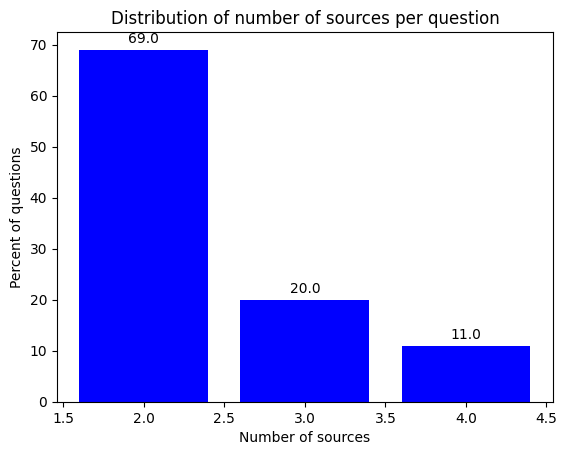

In [143]:
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the number of sources for each question
source_counts = [entry['source_count'] for entry in data]

# Count the occurrences of each source count
count = Counter(source_counts)
source_count_labels, question_counts = zip(*sorted(count.items()))

# Calculate the percentage of questions for each source count
total_questions = sum(question_counts)
percentages = [(count / total_questions) * 100 for count in question_counts]

# Create a bar chart
fig, ax = plt.subplots()

bars = ax.bar(source_count_labels, percentages, color='blue')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('Number of sources')
ax.set_ylabel('Percent of questions')
ax.set_title('Distribution of number of sources per question')

plt.show()

### 7.2. Plot Number of Examples with Similarity Over a Threshold

This section will plot a bar chart showing the number of examples with similarity over a specified threshold.


In [144]:

import json
import matplotlib.pyplot as plt

def plot_success_rate(json_file, similarity_threshold=0.85, model_name='GPT-3.5 Turbo-0125'):
     #Load the JSON data
    with open(json_file, 'r') as file:
         results_data = json.load(file)
    # Count the number of examples with similarity above and below the threshold
    num_examples_above_threshold = sum(1 for entry in results_data if entry['similarity_sources'] > similarity_threshold)
    num_examples_below_threshold = sum(1 for entry in results_data if entry['similarity_sources'] <= similarity_threshold)

    #Calculate the mean similarity for all examples
    similarities = [entry['similarity_sources'] for entry in results_data]
    mean_similarity = np.mean(similarities)

    # Create a bar chart
    fig, ax = plt.subplots()

    bars = ax.bar(['Passed Threshold', 'Failed Threshold'], [num_examples_above_threshold, num_examples_below_threshold], color=['green', 'red'])

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_xlabel(model_name)
    ax.set_ylabel('Number of Examples')
    ax.set_title('Success Rate Based on Similarity Threshold (0.85)')

    plt.show()
    print(f"Mean similarity: {mean_similarity:.2f}")


#### Plots for prompt1

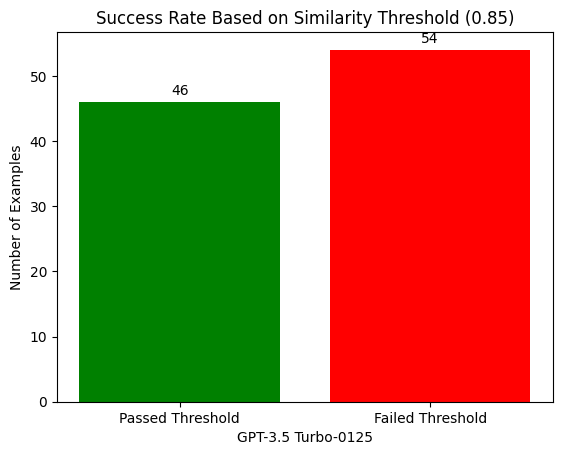

Mean similarity: 0.83


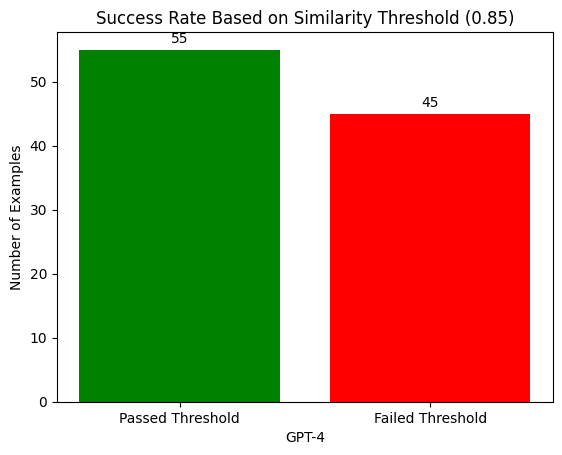

Mean similarity: 0.82


In [145]:

plot_success_rate('answers_gpt-3.5-turbo-0125_prompt1.json', 0.85, 'GPT-3.5 Turbo-0125')
plot_success_rate('answers_gpt-4_prompt1.json', 0.85, 'GPT-4')

#### Plots for Prompt 2

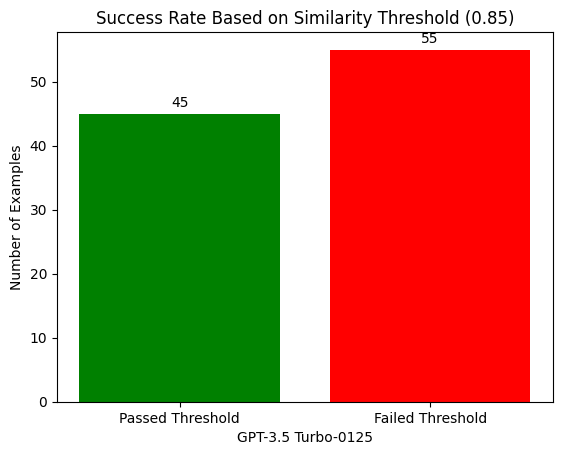

Mean similarity: 0.65


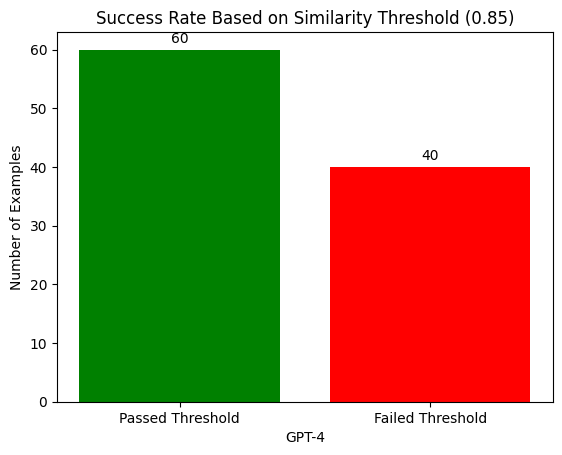

Mean similarity: 0.71


In [147]:
#for prompt 2
plot_success_rate('answers_gpt-3.5-turbo-0125_prompt2.json', 0.85, 'GPT-3.5 Turbo-0125')
plot_success_rate('answers_gpt-4_prompt2.json', 0.85, 'GPT-4')

#### Plots for Prompt 3 -Few-Shots

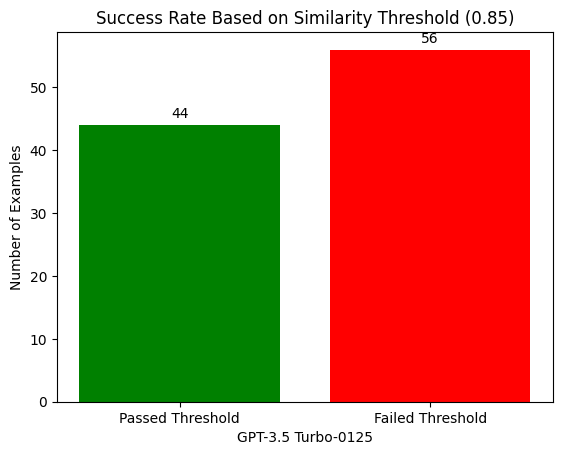

Mean similarity: 0.63


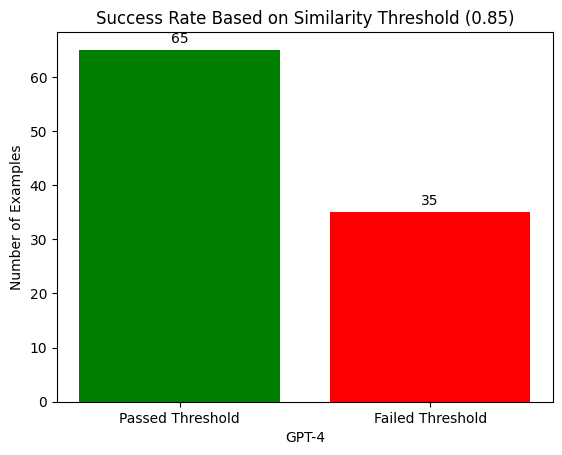

Mean similarity: 0.76


In [151]:
plot_success_rate('answers_gpt-3.5-turbo-0125_few_shots.json', 0.85, 'GPT-3.5 Turbo-0125')
plot_success_rate('answers_gpt-4_few_shots.json', 0.85, 'GPT-4')

#### Plots for Prompt 3 : Dynamic Few-Shots

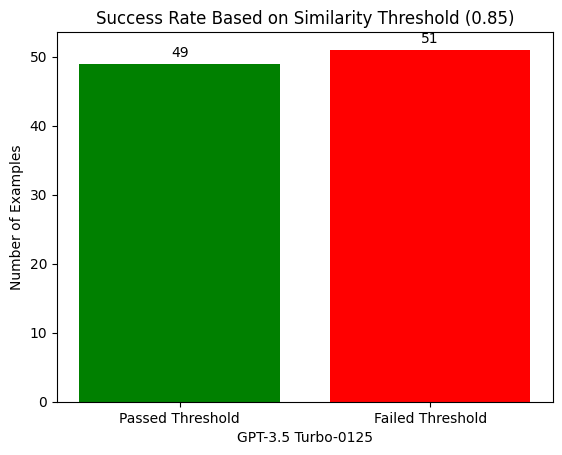

Mean similarity: 0.65


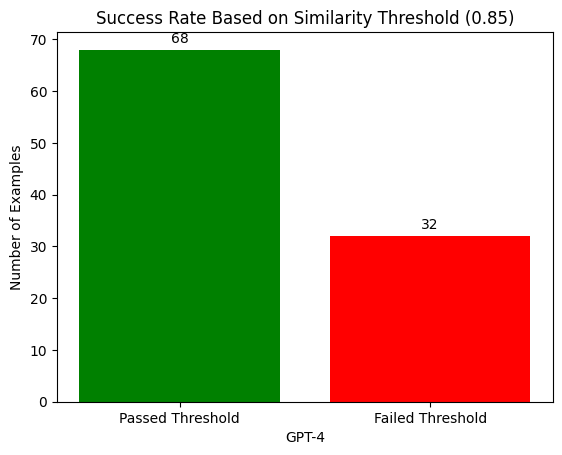

Mean similarity: 0.77


In [152]:
plot_success_rate('answers_gpt-3.5-turbo-0125_dynamic_few_shots.json', 0.85, 'GPT-3.5 Turbo-0125')
plot_success_rate('answers_gpt-4_dynamic_few_shots.json', 0.85, 'GPT-4')

#### Plots for Prompt 4 : Chain-Of-Though

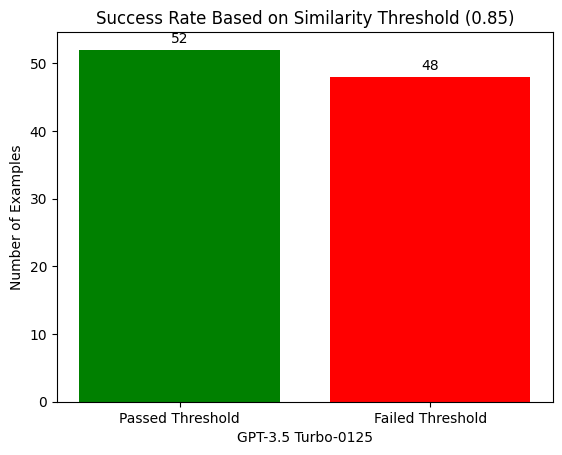

Mean similarity: 0.67


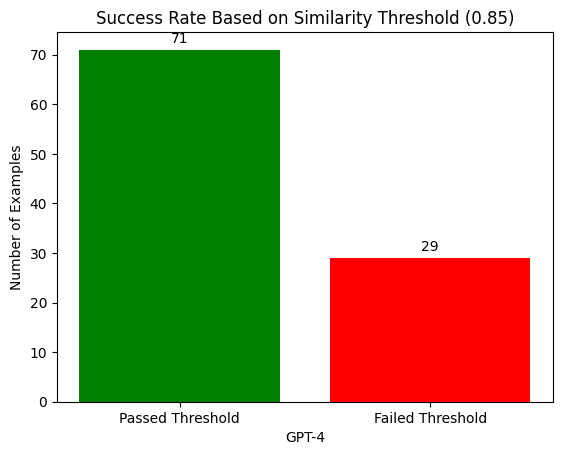

Mean similarity: 0.80


In [153]:
plot_success_rate('answers_gpt-3.5-turbo-0125_chain_of_though.json', 0.85, 'GPT-3.5 Turbo-0125')
plot_success_rate('answers_gpt-4_chain_of_though.json', 0.85, 'GPT-4')

### 7.3. Plot Distribution of Similarity Scores

This section will plot a histogram showing the distribution of similarity scores between the generated and true answers.


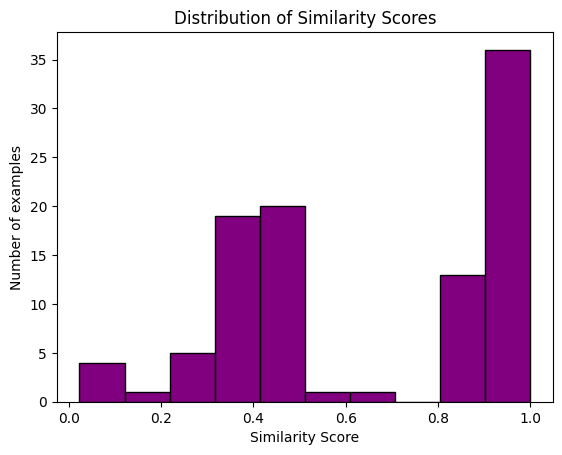

In [ ]:
# Extract similarity scores
results_data = None
with open(output_file_path, 'r') as file:
    results_data = json.load(file)

similarity_scores = [entry['similarity_sources'] for entry in results_data]

# Create a histogram
fig, ax = plt.subplots()

ax.hist(similarity_scores, bins=10, color='purple', edgecolor='black')

ax.set_xlabel('Similarity Score')
ax.set_ylabel('Number of examples')
ax.set_title('Distribution of Similarity Scores')

plt.show()

### 7.4. Plot Distribution of Metrics (F1, ROUGE-L, BERTScore, Similarity)

This section will plot histograms showing the distribution of F1, ROUGE-L, BERTScore, and Similarity for the generated answers.


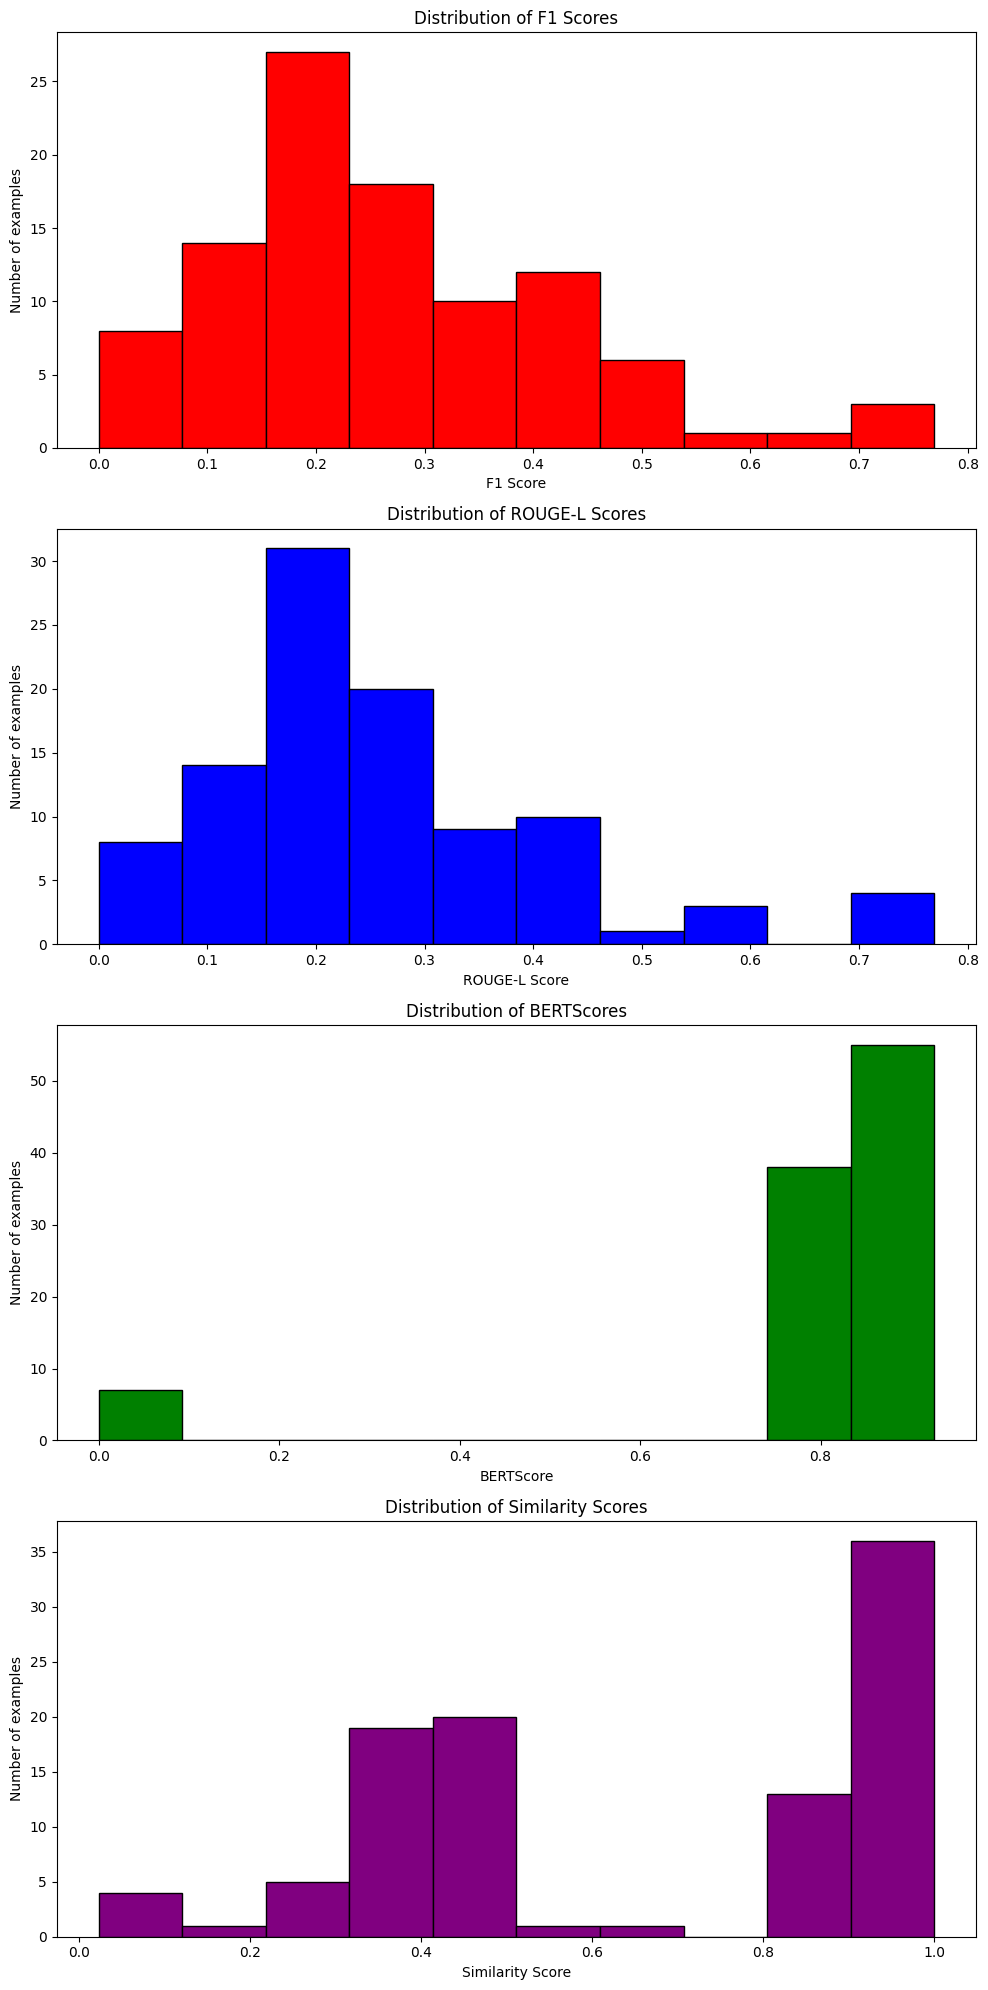

In [ ]:
# Extract metric scores
f1_scores = [entry['f1_score'] for entry in results_data]
rouge_l_scores = [entry['rouge_l_score'] for entry in results_data]
bert_scores = [entry['bert_score'] for entry in results_data]
similarity_scores = [entry['similarity_sources'] for entry in results_data]

# Create histograms
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

# F1 Score
axes[0].hist(f1_scores, bins=10, color='red', edgecolor='black')
axes[0].set_xlabel('F1 Score')
axes[0].set_ylabel('Number of examples')
axes[0].set_title('Distribution of F1 Scores')

# ROUGE-L Score
axes[1].hist(rouge_l_scores, bins=10, color='blue', edgecolor='black')
axes[1].set_xlabel('ROUGE-L Score')
axes[1].set_ylabel('Number of examples')
axes[1].set_title('Distribution of ROUGE-L Scores')

# BERTScore
axes[2].hist(bert_scores, bins=10, color='green', edgecolor='black')
axes[2].set_xlabel('BERTScore')
axes[2].set_ylabel('Number of examples')
axes[2].set_title('Distribution of BERTScores')

# Similarity Score
axes[3].hist(similarity_scores, bins=10, color='purple', edgecolor='black')
axes[3].set_xlabel('Similarity Score')
axes[3].set_ylabel('Number of examples')
axes[3].set_title('Distribution of Similarity Scores')

plt.tight_layout()
plt.show()


In [115]:
def calculate_mean_metrics(results):
    metrics = ['similarity', 'similarity_sources', 'f1_score', 'rouge_l_score', 'bert_score']
    sums = {metric: 0.0 for metric in metrics}
    counts = {metric: 0 for metric in metrics}

    for entry in results:
        for metric in metrics:
            if metric in entry and entry[metric] is not None:
                sums[metric] += entry[metric]
                counts[metric] += 1

    means = {metric: (sums[metric] / counts[metric] if counts[metric] > 0 else None) for metric in metrics}

    return means

In [117]:
output_file_path = 'answers_gpt-4_chain_of_though.json'
results = None
with open(output_file_path, 'r') as file:
    results =  json.load(file)

print(calculate_mean_metrics(results))

{'similarity': 0.8672294394201052, 'similarity_sources': 0.7986147197100525, 'f1_score': 0.5357868836628783, 'rouge_l_score': 0.5645894930123699, 'bert_score': 0.9064751040935516}


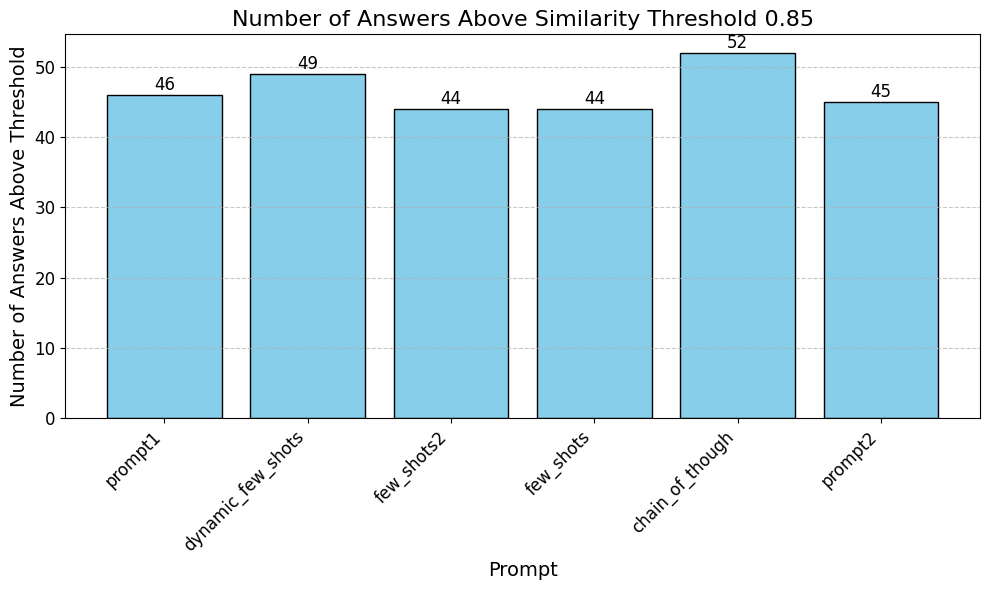

In [113]:
import os
def load_json_files(directory):
    data = []
    filenames = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename), 'r') as file:
                data.append(json.load(file))
                filenames.append(filename)
    return data, filenames

def calculate_above_threshold(data, threshold):
    counts = []
    for prompt_data in data:
        count = sum(1 for entry in prompt_data if entry.get('similarity_sources', 0) > threshold)
        counts.append(count)

    return counts

def extract_prompt_name(filename):
    match = re.search(r'answers_[^_]+_(.+)\.json', filename)
    return match.group(1) if match else filename

def plot_histogram(counts, threshold, labels):
    x = range(len(counts))
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Prompt', fontsize=14)
    plt.ylabel('Number of Answers Above Threshold', fontsize=14)
    plt.title(f'Number of Answers Above Similarity Threshold {threshold}', fontsize=16)
    plt.xticks(x, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adding labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Directory containing your JSON files
directory = './answers_3.5/'


data, filenames = load_json_files(directory)

# Extract prompt names from filenames
labels = [extract_prompt_name(filename) for filename in filenames]

# Define similarity threshold
similarity_threshold = 0.85

# Calculate the number of answers above the threshold for each prompt
counts = calculate_above_threshold(data, similarity_threshold)

# Plot the histogram
plot_histogram(counts, similarity_threshold, labels)